## GANs

In this notebook we train the GAN and inspect its training behaviour.


### Objective

The vanilla adversarial loss

$$
\min _{G} \max _{D} V(D, G)=\mathbb{E}_{x \sim p_{\text {data }}(x)}[\log D(x)]+\mathbb{E}_{z \sim p_{z}(z)}[\log (1-D(G(z)))]
$$

can be implemented straight forward using the discriminator as the gradient source. In our implementation, we first first present the discriminator a real image and then a fake image, with target 1 and 0 respectively. Next, we generate another image and create the objective for the generator by presenting the discriminator the fake image labeled as 1, representing the generators objective directly.


In [1]:
import torch
from IPython import display
from tqdm import tqdm
from torch import nn, optim
from torch.autograd.variable import Variable
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams["figure.figsize"] = (15, 7.5)
%config InlineBackend.figure_format='retina'
%load_ext autoreload

In [2]:
from myGANS import CNNDiscriminator, Discriminator,  Generator, Discriminator2,  Generator2
from training_tools import load_data, imshow, n_params
from fid_score import FID, FID2

## MNIST

Training Parameterization :

In [3]:
dataset = {0 : "mnist", 1 : "svhn"}[0]
discriminator_type = "dense"
latent_dim = 50 #300
eval_fid = False
lr_discriminator = 0.0002
lr_generator = 0.0002
batch_size = 100
num_epochs = 50
input_shape = {"mnist" : (batch_size, 1, 28, 28),
               "svhn"  : (batch_size, 3, 32, 32)}[dataset]

if discriminator_type == "CNN":
    expected_input_shape = input_shape
    discriminator = CNNDiscriminator(expected_input_shape).cuda()
else:
    expected_input_shape = (batch_size, input_shape[1] * input_shape[2] * input_shape[3])
    discriminator = Discriminator2(expected_input_shape).cuda()

generator = Generator2(latent_dim, expected_input_shape).cuda()


In [4]:
n_params(generator) + n_params(discriminator)

999985

In [5]:
X_, V_ = load_data(dataset, test=False, val_frac = .1)
N = X_.shape[0]
if N%batch_size:
    N = N - N%batch_size

### Training

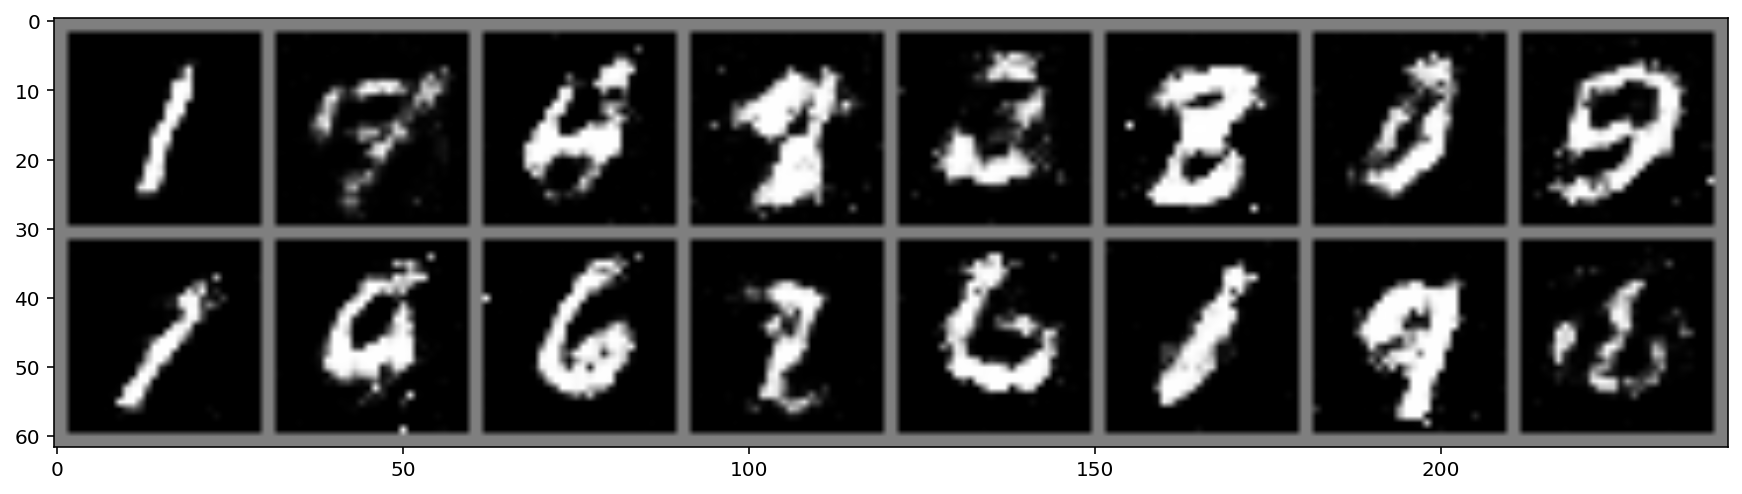

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [03:57<00:00,  4.75s/it]

Wall time: 3min 57s


In [6]:
%%time

d_optimizer = optim.Adam(discriminator.parameters(), lr=lr_discriminator)
g_optimizer = optim.Adam(generator.parameters(), lr=lr_generator)
loss = nn.BCELoss()


epochs = []
fids = []
n_batch = 0
train_index = list(range(N))
for epoch in tqdm(range(num_epochs)):
    data = []
    np.random.shuffle(train_index)
    X_ = X_[train_index].cuda()
    for i in range(0, N, batch_size):
        real_data = X_[i:i+batch_size].reshape(expected_input_shape).float().cuda()
        #  Train Discriminator  
        real_data.requires_grad = True
        random_noise = torch.randn((batch_size, latent_dim),
                                   requires_grad=True).cuda() 
        fake_data = generator(random_noise)#detach?

        d_optimizer.zero_grad()
        
        prediction_real = discriminator(real_data)
        real_data_target = torch.ones((batch_size, 1),
                                      requires_grad=False).cuda()
        error_real = loss(prediction_real, real_data_target)
        error_real.backward()

        prediction_fake = discriminator(fake_data)
        fake_data_target = torch.zeros((batch_size, 1),
                                       requires_grad=False).cuda()
        error_fake = loss(prediction_fake, fake_data_target)
        error_fake.backward()
        d_optimizer.step()

        d_error = error_real + error_fake, prediction_real, prediction_fake

        #  Train Generator
        random_noise = torch.randn((batch_size, latent_dim),
                                   requires_grad=True).cuda() 
        fake_data = generator(random_noise)#detach?
   
        g_optimizer.zero_grad()
    
        prediction = discriminator(fake_data)
        generator_target = torch.ones((batch_size, 1),
                                      requires_grad=False).cuda()
        error = loss(prediction, generator_target)
        error.backward()
        
        g_optimizer.step()
        data += [{"pred_real_d" : error_real.detach().item(),
                  "pred_fake_d" : error_fake.detach().item(),
                  "pred_fake_g" : error.detach().item(),
                
                 }]
    
    epochs.append(pd.DataFrame(data).mean())
    print("End of Epoch %s" % epoch)
    with torch.no_grad():
        display.clear_output(True)
        s = 16
        sample = torch.randn((batch_size, latent_dim), requires_grad=False).cuda() 
        sample = generator(sample.detach())
        sample = sample.reshape(batch_size,
                            input_shape[1],
                           input_shape[2],
                           input_shape[3])
        imshow(sample[:s])
        if eval_fid:
            # Compare with random sample from val
            real = V_[np.random.choice(list(range(V_.shape[0])), batch_size)]
            fid = FID2(real, sample, False)
            fids.append(fid)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

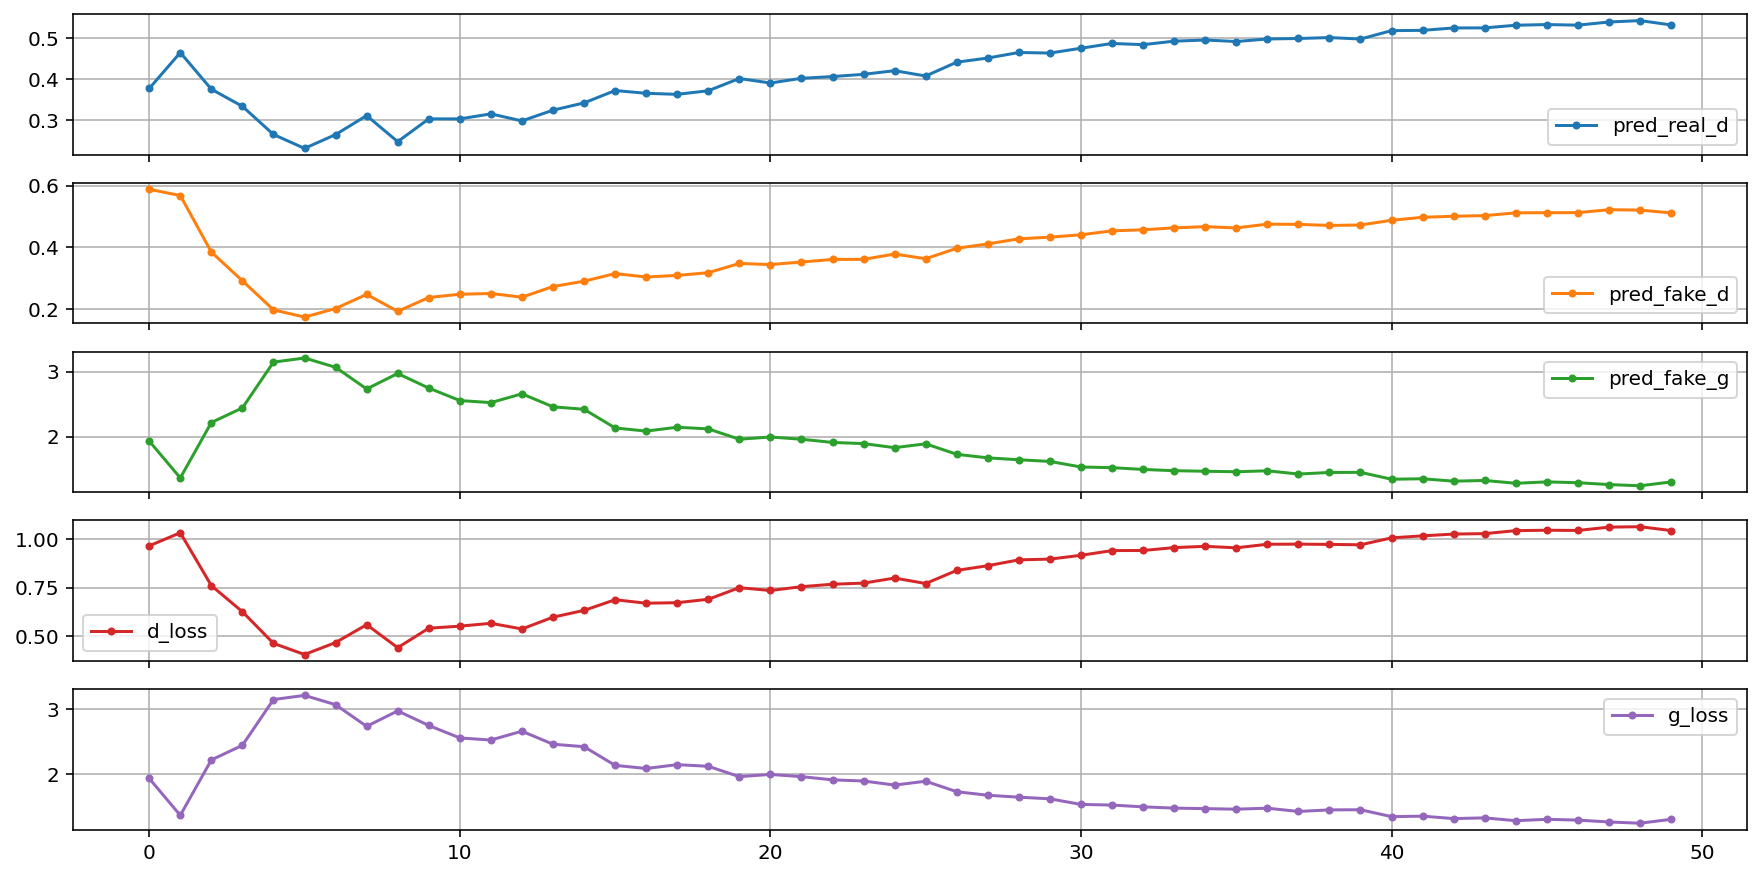

In [9]:
df = pd.DataFrame(epochs)
df["d_loss"] = df["pred_real_d"] + df["pred_fake_d"]
df["g_loss"] = df["pred_fake_g"]
df["fid"] = fids if eval_fid else None
df.plot(subplots=True, style=".-",grid=True)

The training learning curve(s) looks reasonable to us. Initially, the discriminator is dominating in terms of optimizing its objective, but at some point the models seem to converge to a state in which the generator gets better and better, finally being able to consistently fool the discriminator.

## Sample Images

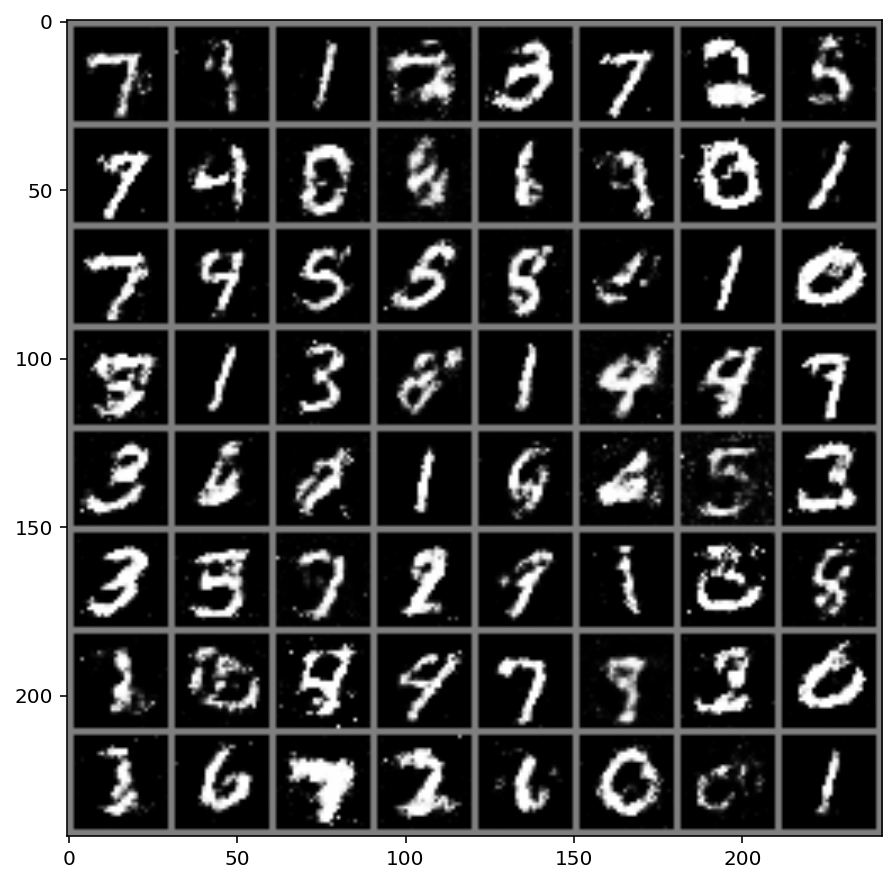

In [13]:
with torch.no_grad():
    generator.eval()
    s = 64

    X = torch.randn((s, latent_dim), requires_grad=False).cuda() 
    fake = generator(X.detach())
    fake = fake.reshape(s,
                        input_shape[1],
                       input_shape[2],
                       input_shape[3])
    imshow(fake)

The generated images look reasonable, but the generations are far from perfect. More tuning would help, but given the extreme training instability we are happy with this result.

In [14]:
# Save model for inference
PATH = "mnist_generator.pt"
torch.save(generator, PATH)

## SVHN

Training Parameterization :

In [16]:
dataset = {0 : "mnist", 1 : "svhn"}[1]
discriminator_type = "dense"
latent_dim = 50 #300
eval_fid = False
lr_discriminator = 0.0002
lr_generator = 0.0002
batch_size = 100
num_epochs = 50
input_shape = {"mnist" : (batch_size, 1, 28, 28),
               "svhn"  : (batch_size, 3, 32, 32)}[dataset]

if discriminator_type == "CNN":
    expected_input_shape = input_shape
    discriminator = CNNDiscriminator(expected_input_shape).cuda()
else:
    expected_input_shape = (batch_size, input_shape[1] * input_shape[2] * input_shape[3])
    discriminator = Discriminator2(expected_input_shape).cuda()

generator = Generator2(latent_dim, expected_input_shape).cuda()


In [17]:
n_params(generator) + n_params(discriminator)

2832673

In [18]:
X_, V_ = load_data(dataset, test=False, val_frac = .1)
N = X_.shape[0]
if N%batch_size:
    N = N - N%batch_size

Using downloaded and verified file: ./SVHN/dataset\train_32x32.mat


### Training

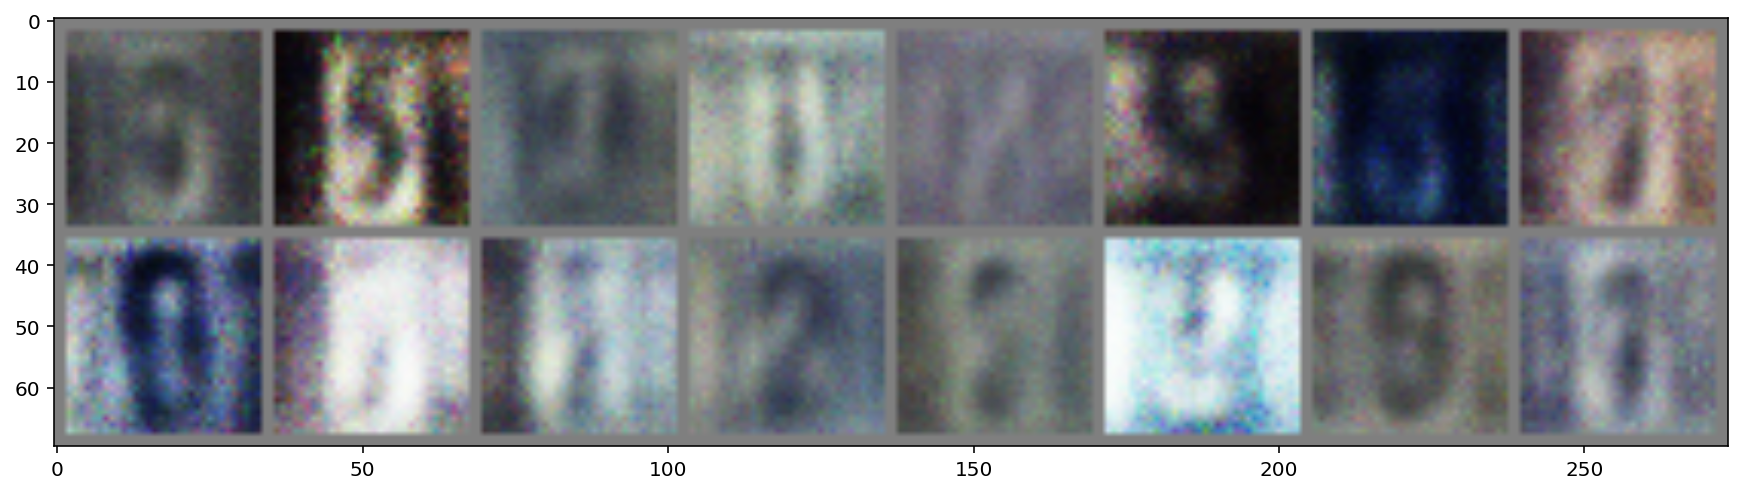

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [05:38<00:00,  6.77s/it]

Wall time: 5min 38s


In [19]:
%%time

d_optimizer = optim.Adam(discriminator.parameters(), lr=lr_discriminator)
g_optimizer = optim.Adam(generator.parameters(), lr=lr_generator)
loss = nn.BCELoss()


epochs = []
fids = []
n_batch = 0
train_index = list(range(N))
for epoch in tqdm(range(num_epochs)):
    data = []
    np.random.shuffle(train_index)
    X_ = X_[train_index].cuda()
    for i in range(0, N, batch_size):
        real_data = X_[i:i+batch_size].reshape(expected_input_shape).float().cuda()
        #  Train Discriminator  
        real_data.requires_grad = True
        random_noise = torch.randn((batch_size, latent_dim),
                                   requires_grad=True).cuda() 
        fake_data = generator(random_noise)#detach?

        d_optimizer.zero_grad()
        
        prediction_real = discriminator(real_data)
        real_data_target = torch.ones((batch_size, 1),
                                      requires_grad=False).cuda()
        error_real = loss(prediction_real, real_data_target)
        error_real.backward()

        prediction_fake = discriminator(fake_data)
        fake_data_target = torch.zeros((batch_size, 1),
                                       requires_grad=False).cuda()
        error_fake = loss(prediction_fake, fake_data_target)
        error_fake.backward()
        d_optimizer.step()

        d_error = error_real + error_fake, prediction_real, prediction_fake

        #  Train Generator
        random_noise = torch.randn((batch_size, latent_dim),
                                   requires_grad=True).cuda() 
        fake_data = generator(random_noise)#detach?
   
        g_optimizer.zero_grad()
    
        prediction = discriminator(fake_data)
        generator_target = torch.ones((batch_size, 1),
                                      requires_grad=False).cuda()
        error = loss(prediction, generator_target)
        error.backward()
        
        g_optimizer.step()
        data += [{"pred_real_d" : error_real.detach().item(),
                  "pred_fake_d" : error_fake.detach().item(),
                  "pred_fake_g" : error.detach().item(),
                
                 }]
    
    epochs.append(pd.DataFrame(data).mean())
    print("End of Epoch %s" % epoch)
    with torch.no_grad():
        display.clear_output(True)
        s = 16
        sample = torch.randn((s, latent_dim), requires_grad=False).cuda() 
        imgs = generator(sample.detach())
        imgs = imgs.reshape(s,
                            input_shape[1],
                           input_shape[2],
                           input_shape[3])
        imshow(imgs)
        if eval_fid:
            # Compare with random sample from val
            real = V_[np.random.choice(list(range(V_.shape[0])), batch_size)]
            fid = FID2(real, sample, False)
            fids.append(fid)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

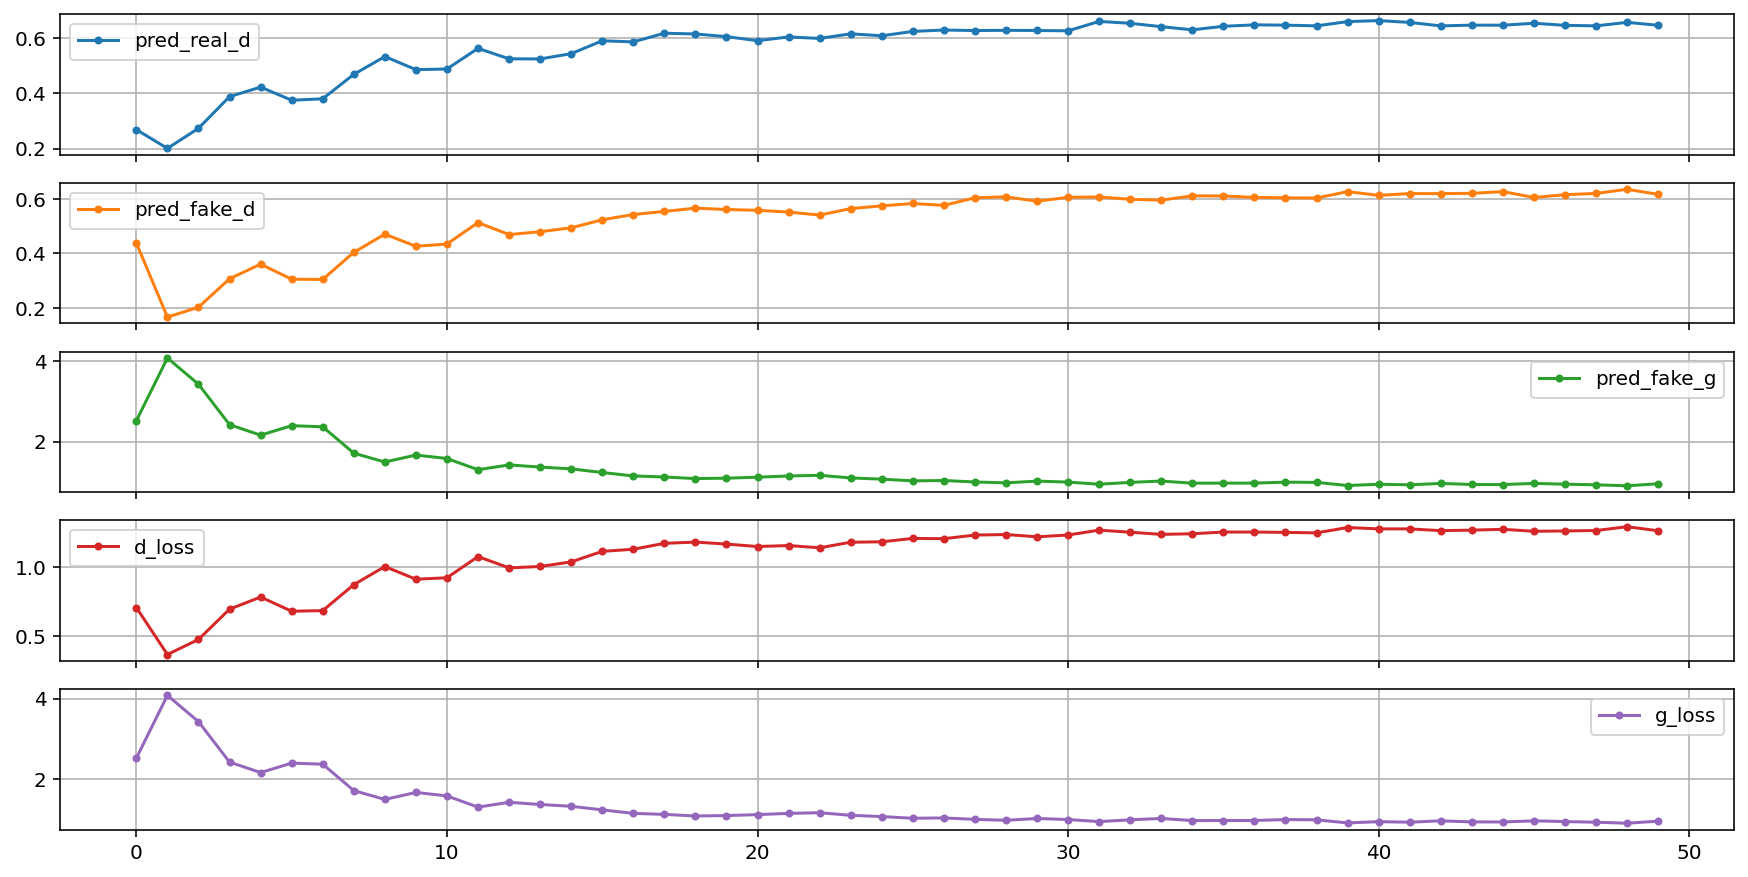

In [20]:
df = pd.DataFrame(epochs)
df["d_loss"] = df["pred_real_d"] + df["pred_fake_d"]
df["g_loss"] = df["pred_fake_g"]
df.plot(subplots=True, style=".-",grid=True)

## Sample Images

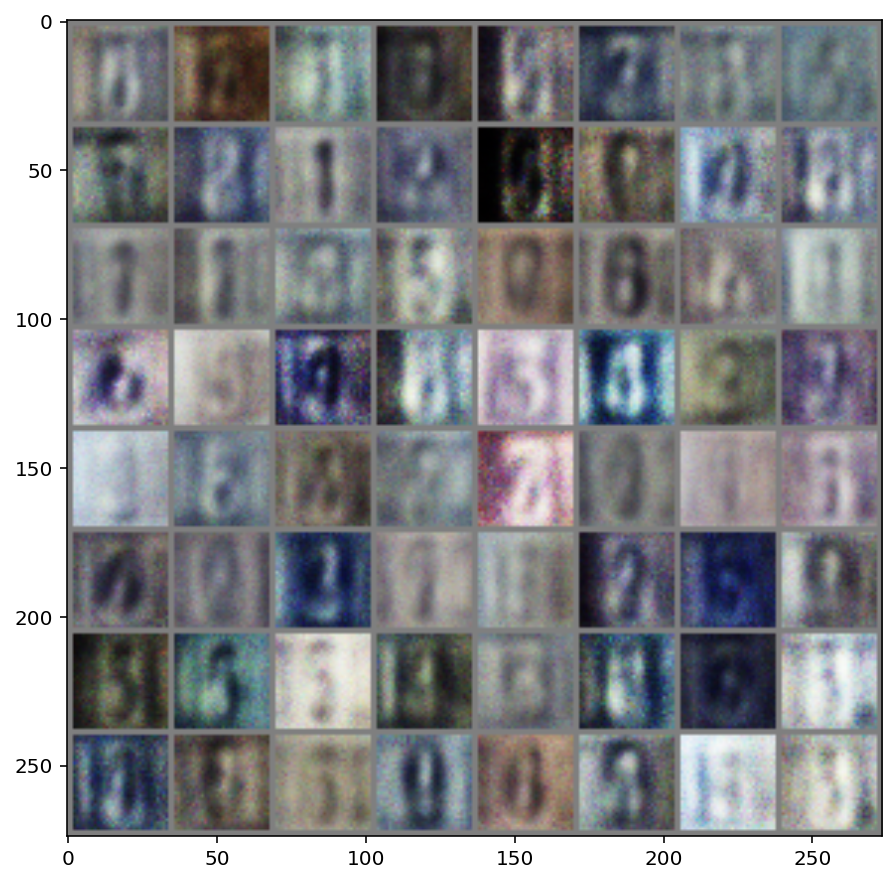

In [26]:
with torch.no_grad():
    generator.eval()
    s = 64

    X = torch.randn((s, latent_dim), requires_grad=False).cuda() 
    fake = generator(X.detach())
    fake = fake.reshape(s,
                        input_shape[1],
                       input_shape[2],
                       input_shape[3])
    imshow(fake)

In [27]:
# Save model for inference
PATH = "svhn_generator.pt"
torch.save(generator, PATH)

## Conclusive Note on training the GAN

Training the GAN turned out to be extremely hairy. Most of the time we would observe mode collapse at some point of the training. Finding a set of hyperparameters that work in a stable way is hard and the learning rate turned out to be the most crucial parameter. We also tried to counter the mode collapse by incorporating the variance of the samples of the generated batch into the objective of the generator, which kind of works but reduces the overall image quality. We also tried to smooth the labels 1 <- U(.75, 1.) and 0 <- U(0., .25) but with no significant improvements. After we finally found a good parameter set, the GAN works well!